## Basic Structure of the Code

* EDA on normal data
* LSTM on normal data
* LSTM on feature engineered data (moving average)
* LSTM on normal data with SMOTE
* LSTM on feature engineered data with SMOTE


In [1]:
# reading data from source

import pandas as pd
data=pd.read_csv('Documents\ec2_cpu_utilization_24ae8d.csv')

In [2]:
df=pd.DataFrame(data)

### EDA on normal data

In [3]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

label
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

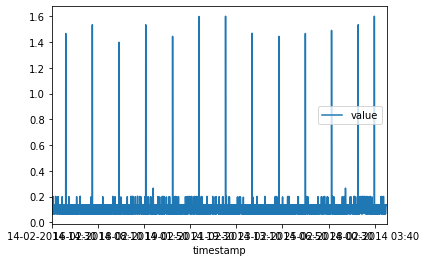

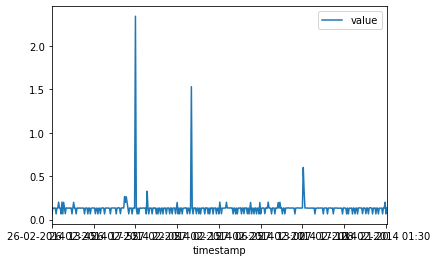

In [4]:
#Following is the plot of both the labels 0 and 1 seperately showing their corresponding pattern

df.groupby('label').plot.line(x='timestamp', y= 'value')

label
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

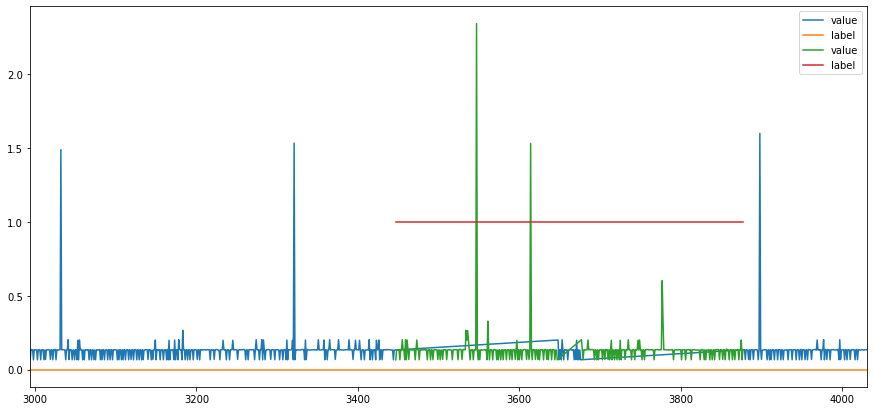

In [5]:
#following is the plot showing anomalous data showing seperately in green color 

fig, ax = plt.subplots(figsize=(15,7))
y1 = df[(df['timestamp'] >= '25-02-2014  00:00:00')& (df['timestamp'] <= '28-02-2014 14:25:00')]
y1.groupby('label').plot(ax=ax)

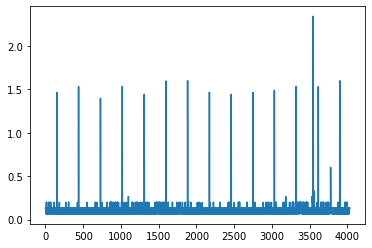

In [6]:
# normal plot of values to see the trigger of anomalous behaviour

plt.plot(df['value'])

#### Applying Z-score to the data and try to remove outliers from the data

In [7]:
from scipy import stats
import numpy as np
from sklearn.metrics import confusion_matrix,f1_score
from sklearn.metrics import classification_report

X_in=data['value']
Y_in=data['label']

X_in=X_in.values
Y_in=Y_in.values



z_score=stats.zscore(X_in)


std_dev=np.std(X_in)

ypred=[]
for i in z_score:
    if(i>=1.96 or i<=-1.96):
        ypred.append(1)
    else:
        ypred.append(0)
ypred=np.array(ypred)


print(classification_report(Y_in, ypred))
print("F1 Score=",f1_score(Y_in,ypred))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95      3630
           1       0.28      0.01      0.02       402

    accuracy                           0.90      4032
   macro avg       0.59      0.50      0.49      4032
weighted avg       0.84      0.90      0.85      4032

F1 Score= 0.02380952380952381


#### Calculating Z-score for moving avg Data

In [8]:
MX=data['value'].rolling(window=10).mean()
MX=pd.DataFrame(MX)

MX.columns=['avg']
MX.loc[MX['avg'].isnull(),'avg'] = .132

MX=MX.values

Mz_score=stats.zscore(MX)
Mstd_dev=np.std(MX)

Mypred=[]
for i in z_score:
    if(i>=1.96 or i<=-1.96):
        Mypred.append(1)
    else:
        Mypred.append(0)
Mypred=np.array(Mypred)

print(classification_report(Y_in, Mypred))
print("F1 Score=",f1_score(Y_in,Mypred))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95      3630
           1       0.28      0.01      0.02       402

    accuracy                           0.90      4032
   macro avg       0.59      0.50      0.49      4032
weighted avg       0.84      0.90      0.85      4032

F1 Score= 0.02380952380952381


#### As we can see basic EDA and Outlier removal using Z-score wont help much and we need better algorithm to detect anomaly and have stable and consistent results in real time too.

#### 1. Applying LSTM to normal data extracted from the .csv file

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import confusion_matrix,f1_score
from sklearn.metrics import classification_report


X_in=df['value']
Y_in=df['label']
X_in=X_in.values


trainX=X_in.reshape((X_in.shape[0],1,1))

model = Sequential()
model.add(LSTM(4, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
print(model.summary())
model.fit(trainX,Y_in, epochs=100, batch_size=10, verbose=2)



Using TensorFlow backend.







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 4)                 96        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________
None

Epoch 1/100
 - 3s - loss: 0.5684 - binary_accuracy: 0.8740
Epoch 2/100
 - 1s - loss: 0.3596 - binary_accuracy: 0.9003
Epoch 3/100
 - 1s - loss: 0.3267 - binary_accuracy: 0.9003
Epoch 4/100
 - 1s - loss: 0.3256 - binary_accuracy: 0.9003
Epoch 5/100
 - 1s - loss: 0.3254 - binary_accuracy: 0.9003
Epoch 6/100
 - 1s - loss: 0.3255 - binary_accuracy: 0.9003
Epoch 7/100
 - 1s - loss: 0.3253 - binary_accuracy: 0.9003
Epoch 8/100
 - 1s - lo

In [10]:
ypred = model.predict(trainX)

avg =np.mean(ypred)

ypred1=[]
for i in ypred:
    if(i>=avg):
        ypred1.append(1)
    else:
        ypred1.append(0)

ypred1=np.array(ypred1)


print(classification_report(Y_in, ypred1))
print(confusion_matrix(Y_in,ypred1))
print("F1 Score=",f1_score(Y_in,ypred1))

              precision    recall  f1-score   support

           0       0.90      0.96      0.93      3630
           1       0.14      0.06      0.08       402

    accuracy                           0.87      4032
   macro avg       0.52      0.51      0.51      4032
weighted avg       0.83      0.87      0.85      4032

[[3491  139]
 [ 379   23]]
F1 Score= 0.08156028368794327


#### This yet can be improved by taking feature engineering into account therefor applying 
#### 2. LSTM on feature engineered data (moving average)

In [11]:
trainmx=MX.reshape((MX.shape[0],1,1))

model = Sequential()
model.add(LSTM(4, input_shape=(trainmx.shape[1], trainmx.shape[2])))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
print(model.summary())
model.fit(trainmx,Y_in, epochs=200, batch_size=10, verbose=2)




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 4)                 96        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200
 - 2s - loss: 0.5480 - binary_accuracy: 0.8827
Epoch 2/200
 - 1s - loss: 0.3515 - binary_accuracy: 0.9003
Epoch 3/200
 - 1s - loss: 0.3269 - binary_accuracy: 0.9003
Epoch 4/200
 - 1s - loss: 0.3257 - binary_accuracy: 0.9003
Epoch 5/200
 - 1s - loss: 0.3257 - binary_accuracy: 0.9003
Epoch 6/200
 - 1s - loss: 0.3256 - binary_accuracy: 0.9003
Epoch 7/200
 - 1s - loss: 0.3256 - binary_accuracy: 0.9003
Epoch 8/200
 - 1s - loss: 0.3255 - binary_accuracy: 0.9003
Epoch 9/200
 - 1s - loss: 0.3255 - binary_accuracy: 0.9003
Epoc

Epoch 128/200
 - 1s - loss: 0.3220 - binary_accuracy: 0.9003
Epoch 129/200
 - 1s - loss: 0.3218 - binary_accuracy: 0.9003
Epoch 130/200
 - 1s - loss: 0.3219 - binary_accuracy: 0.9003
Epoch 131/200
 - 1s - loss: 0.3218 - binary_accuracy: 0.9003
Epoch 132/200
 - 1s - loss: 0.3220 - binary_accuracy: 0.9003
Epoch 133/200
 - 1s - loss: 0.3219 - binary_accuracy: 0.9003
Epoch 134/200
 - 1s - loss: 0.3218 - binary_accuracy: 0.9003
Epoch 135/200
 - 1s - loss: 0.3218 - binary_accuracy: 0.9003
Epoch 136/200
 - 1s - loss: 0.3218 - binary_accuracy: 0.9003
Epoch 137/200
 - 1s - loss: 0.3217 - binary_accuracy: 0.9003
Epoch 138/200
 - 1s - loss: 0.3220 - binary_accuracy: 0.9003
Epoch 139/200
 - 1s - loss: 0.3219 - binary_accuracy: 0.9003
Epoch 140/200
 - 1s - loss: 0.3218 - binary_accuracy: 0.9003
Epoch 141/200
 - 1s - loss: 0.3218 - binary_accuracy: 0.9003
Epoch 142/200
 - 1s - loss: 0.3218 - binary_accuracy: 0.9003
Epoch 143/200
 - 1s - loss: 0.3219 - binary_accuracy: 0.9003
Epoch 144/200
 - 1s - lo

In [12]:
mypred = model.predict(trainmx)

avg =np.mean(mypred)

mypred1=[]
for i in mypred:
    if(i>=avg):
        mypred1.append(1)
    else:
        mypred1.append(0)

mypred1=np.array(mypred1)


print(classification_report(Y_in, mypred1))
print(confusion_matrix(Y_in,mypred1))
print("F1 Score=",f1_score(Y_in,mypred1))


              precision    recall  f1-score   support

           0       0.91      0.86      0.89      3630
           1       0.16      0.24      0.19       402

    accuracy                           0.80      4032
   macro avg       0.54      0.55      0.54      4032
weighted avg       0.84      0.80      0.82      4032

[[3133  497]
 [ 307   95]]
F1 Score= 0.19114688128772636


as the data is imbalanced we can try to make it balanced using SMOTE on both normal and average data

In [13]:
!pip install imblearn

#### 3. LSTM on normal data with SMOTE

In [14]:
from imblearn.over_sampling import SMOTE

X_sm=np.array(X_in)
Y_sm=np.array(Y_in)

X_sm=X_sm.reshape(-1,1)
Y_sm=Y_sm.reshape(-1,1)

X_sm,Y_sm=SMOTE(random_state=2).fit_resample(X_sm,Y_sm.ravel())

trainX_sm=X_sm.reshape(X_sm.shape[0],1,1)
trainY_sm=Y_sm.reshape(Y_sm.shape[0],1,1)

model = Sequential()
model.add(LSTM(4, input_shape=(trainX_sm.shape[1], trainX_sm.shape[2])))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
print(model.summary())
model.fit(trainX_sm,Y_sm, epochs=200, batch_size=10, verbose=2)



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 4)                 96        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200
 - 3s - loss: 0.6933 - binary_accuracy: 0.4846
Epoch 2/200
 - 2s - loss: 0.6933 - binary_accuracy: 0.4974
Epoch 3/200
 - 2s - loss: 0.6932 - binary_accuracy: 0.4931
Epoch 4/200
 - 2s - loss: 0.6933 - binary_accuracy: 0.4986
Epoch 5/200
 - 2s - loss: 0.6932 - binary_accuracy: 0.5032
Epoch 6/200
 - 2s - loss: 0.6932 - binary_accuracy: 0.4948
Epoch 7/200
 - 2s - loss: 0.6932 - binary_accuracy: 0.4990
Epoch 8/200
 - 2s - loss: 0.6932 - binary_accuracy: 0.4949
Epoch 9/200
 - 2s - loss: 0.6932 - binary_accuracy: 0.4933
Epoc

Epoch 128/200
 - 2s - loss: 0.6917 - binary_accuracy: 0.5102
Epoch 129/200
 - 2s - loss: 0.6916 - binary_accuracy: 0.5066
Epoch 130/200
 - 2s - loss: 0.6915 - binary_accuracy: 0.5120
Epoch 131/200
 - 2s - loss: 0.6915 - binary_accuracy: 0.5145
Epoch 132/200
 - 2s - loss: 0.6915 - binary_accuracy: 0.5091
Epoch 133/200
 - 2s - loss: 0.6917 - binary_accuracy: 0.5092
Epoch 134/200
 - 2s - loss: 0.6917 - binary_accuracy: 0.5061
Epoch 135/200
 - 2s - loss: 0.6916 - binary_accuracy: 0.5063
Epoch 136/200
 - 2s - loss: 0.6915 - binary_accuracy: 0.5073
Epoch 137/200
 - 2s - loss: 0.6916 - binary_accuracy: 0.5116
Epoch 138/200
 - 2s - loss: 0.6916 - binary_accuracy: 0.5051
Epoch 139/200
 - 2s - loss: 0.6916 - binary_accuracy: 0.5055
Epoch 140/200
 - 2s - loss: 0.6915 - binary_accuracy: 0.5083
Epoch 141/200
 - 2s - loss: 0.6916 - binary_accuracy: 0.5088
Epoch 142/200
 - 2s - loss: 0.6916 - binary_accuracy: 0.5092
Epoch 143/200
 - 2s - loss: 0.6916 - binary_accuracy: 0.5054
Epoch 144/200
 - 2s - lo

In [15]:
ypred_sm = model.predict(trainX)

avg =np.mean(ypred_sm)

ypred1_sm=[]
for i in ypred_sm:
    if(i>=avg):
        ypred1_sm.append(1)
    else:
        ypred1_sm.append(0)

ypred1_sm=np.array(ypred1_sm)


print(classification_report(Y_in, ypred1_sm))
print(confusion_matrix(Y_in,ypred1_sm))
print("F1 Score=",f1_score(Y_in,ypred1_sm))


              precision    recall  f1-score   support

           0       0.91      0.23      0.37      3630
           1       0.10      0.79      0.18       402

    accuracy                           0.29      4032
   macro avg       0.50      0.51      0.27      4032
weighted avg       0.83      0.29      0.35      4032

[[ 837 2793]
 [  86  316]]
F1 Score= 0.18000569638279693


#### 4. LSTM on feature engineered data with SMOTE

In [16]:
MX_sm=np.array(MX)
Y_sm=np.array(Y_in)

MX_sm=MX_sm.reshape(-1,1)
Y_sm=Y_sm.reshape(-1,1)

MX_sm,Y_sm=SMOTE(random_state=2).fit_resample(MX_sm,Y_sm.ravel())

trainMX_sm=MX_sm.reshape(X_sm.shape[0],1,1)
trainY_sm=Y_sm.reshape(Y_sm.shape[0],1,1)

model = Sequential()
model.add(LSTM(4, input_shape=(trainMX_sm.shape[1], trainMX_sm.shape[2])))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
print(model.summary())
model.fit(trainMX_sm,Y_sm, epochs=200, batch_size=20, verbose=2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 4)                 96        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200
 - 4s - loss: 0.6930 - binary_accuracy: 0.5010
Epoch 2/200
 - 1s - loss: 0.6929 - binary_accuracy: 0.4982
Epoch 3/200
 - 1s - loss: 0.6927 - binary_accuracy: 0.5033
Epoch 4/200
 - 1s - loss: 0.6925 - binary_accuracy: 0.5266
Epoch 5/200
 - 1s - loss: 0.6923 - binary_accuracy: 0.5167
Epoch 6/200
 - 1s - loss: 0.6920 - binary_accuracy: 0.5325
Epoch 7/200
 - 1s - loss: 0.6918 - binary_accuracy: 0.5140
Epoch 8/200
 - 1s - loss: 0.6913 - binary_accuracy: 0.5289
Epoch 9/200
 - 1s - loss: 0.6909 - binary_accuracy: 0.5275
Epoc

Epoch 128/200
 - 1s - loss: 0.6864 - binary_accuracy: 0.5529
Epoch 129/200
 - 1s - loss: 0.6864 - binary_accuracy: 0.5512
Epoch 130/200
 - 1s - loss: 0.6864 - binary_accuracy: 0.5507
Epoch 131/200
 - 1s - loss: 0.6865 - binary_accuracy: 0.5552
Epoch 132/200
 - 1s - loss: 0.6865 - binary_accuracy: 0.5518
Epoch 133/200
 - 1s - loss: 0.6866 - binary_accuracy: 0.5534
Epoch 134/200
 - 1s - loss: 0.6864 - binary_accuracy: 0.5479
Epoch 135/200
 - 1s - loss: 0.6867 - binary_accuracy: 0.5529
Epoch 136/200
 - 1s - loss: 0.6866 - binary_accuracy: 0.5501
Epoch 137/200
 - 1s - loss: 0.6866 - binary_accuracy: 0.5529
Epoch 138/200
 - 1s - loss: 0.6866 - binary_accuracy: 0.5518
Epoch 139/200
 - 1s - loss: 0.6865 - binary_accuracy: 0.5576
Epoch 140/200
 - 1s - loss: 0.6866 - binary_accuracy: 0.5492
Epoch 141/200
 - 1s - loss: 0.6867 - binary_accuracy: 0.5518
Epoch 142/200
 - 1s - loss: 0.6866 - binary_accuracy: 0.5506
Epoch 143/200
 - 1s - loss: 0.6866 - binary_accuracy: 0.5485
Epoch 144/200
 - 1s - lo

In [17]:
Mypred_sm = model.predict(trainmx)

avg =np.mean(Mypred_sm)

Mypred1_sm=[]
for i in Mypred_sm:
    if(i>=avg):
        Mypred1_sm.append(1)
    else:
        Mypred1_sm.append(0)

Mypred1_sm=np.array(Mypred1_sm)


print(classification_report(Y_in, Mypred1_sm))
print(confusion_matrix(Y_in,Mypred1_sm))
print("F1 Score=",f1_score(Y_in,Mypred1_sm))

              precision    recall  f1-score   support

           0       0.92      0.66      0.77      3630
           1       0.13      0.45      0.20       402

    accuracy                           0.64      4032
   macro avg       0.52      0.56      0.48      4032
weighted avg       0.84      0.64      0.71      4032

[[2401 1229]
 [ 221  181]]
F1 Score= 0.19977924944812359


## Conclusion
#### As seen from the output of several combinations the most stable appraoch is LSTM on feature engineered data where we calculated moving average for a window of 10 and applied LSTM on it.
#### SMOTE is not giving good results because the anomaly is collective in nature and data generation on random fashion to equalise minority and majority wont help.
#### Therefore, the most reliable approach is to maitaing moving average over a window and train the model accordingly for better results.